In [1]:
# to disable GPU
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import os
# os.chdir('T:/Dropbox/Projects/LSTM-forecast/src')
import featureEng as fe
import processStocks as ps
import lstm
import getStocks
import visualize
import predicts
import pandas as pd

/usr/local/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [4]:
# view tenslow enabled devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9226074297802423653
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7549114778
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1314512787854773845
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


# User parameters

In [5]:
####TODO: reshaping so we can plot various n_in, n_out
# model seems to work, but cant redim for plot
ticker = 'unh'
n_in = 5 #number of historical days to input
n_out = 5
target = 'Close'
rngSpt = 20 # number of random stocks to select as the supporting data features

In [6]:
# collect a bunch of data from the market, save it to directory
# getStocks.get_mkt_data(source='yahoo')

# Load Data
### Several methods available here:
* Load a single stock
* get a refresh of the stock
* load a single stock as the target while using many other stocks as additional features

In [7]:
# load dataset
# dataset = getStocks.get_single(ticker=ticker, save=True)
# dataset = getStocks.load_single(ticker)
dataset = getStocks.join_tgt_spt(target_ticker=ticker.upper(), number_spt=rngSpt)
dataset.reset_index(level=0, inplace=True)
dataset.rename(columns={'Adj Close':'AdjCls'}, inplace=True)

In [8]:
import TS_LSTM as ts_lstm
import imp
imp.reload(ts_lstm)

<module 'TS_LSTM' from '/mnt/data/Dropbox/Projects/LSTM-forecast/src/TS_LSTM.py'>

In [9]:
# build base object
mod = ts_lstm.TS_LSTM(n_in=5, n_out=5, 
                      ticker='UNH',target='Close',
                      rawData=dataset)
# do feature engineering
mod.eng_features()
mod.roll_data()
mod.tscv()

/mnt/data/Dropbox/Projects/LSTM-forecast/src/featureEng.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataset.drop(['Date'], axis=1, inplace=True)


starting Series to supverised conversion...


# Build LSTM Architecture

In [10]:
# for debug on lstm package
import imp
imp.reload(lstm)

<module 'lstm' from '/mnt/data/Dropbox/Projects/LSTM-forecast/src/lstm.py'>

In [11]:
train_X = mod.train_X
train_y = mod.train_y
test_X = mod.test_X
test_y = mod.test_y

In [12]:
model = lstm.build_model(train_X, loss_function='mean_absolute_percentage_error',
                         timesteps=n_in, 
                         inlayer=int(train_X.shape[-1]*.75),
                         hiddenlayers=[10, 5], 
                         outlayer=n_out)

Compilation Time :  0.014153242111206055
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 101)            95748     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 101)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             4480      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None,

In [13]:
mod.build_model(hiddenlayers=[10, 5])

Compilation Time :  0.013660907745361328
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 101)            95748     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 101)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 10)             4480      
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 10)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5)                 320       
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None,

# Fit model

Train on 648 samples, validate on 163 samples
Epoch 1/50
 - 2s - loss: 99.9700 - val_loss: 99.9678
Epoch 2/50
 - 0s - loss: 99.9483 - val_loss: 99.9533
Epoch 3/50
 - 0s - loss: 99.9277 - val_loss: 99.9381
Epoch 4/50
 - 0s - loss: 99.9037 - val_loss: 99.9228
Epoch 5/50
 - 0s - loss: 99.8850 - val_loss: 99.9072
Epoch 6/50
 - 0s - loss: 99.8571 - val_loss: 99.8914
Epoch 7/50
 - 0s - loss: 99.8360 - val_loss: 99.8752
Epoch 8/50
 - 0s - loss: 99.8158 - val_loss: 99.8585
Epoch 9/50
 - 0s - loss: 99.7891 - val_loss: 99.8413
Epoch 10/50
 - 0s - loss: 99.7622 - val_loss: 99.8238
Epoch 11/50
 - 0s - loss: 99.7376 - val_loss: 99.8060
Epoch 12/50
 - 0s - loss: 99.7188 - val_loss: 99.7882
Epoch 13/50
 - 0s - loss: 99.6876 - val_loss: 99.7707
Epoch 14/50
 - 0s - loss: 99.6609 - val_loss: 99.7535
Epoch 15/50
 - 0s - loss: 99.6458 - val_loss: 99.7370
Epoch 16/50
 - 0s - loss: 99.6068 - val_loss: 99.7211
Epoch 17/50
 - 0s - loss: 99.5995 - val_loss: 99.7060
Epoch 18/50
 - 0s - loss: 99.5759 - val_loss:

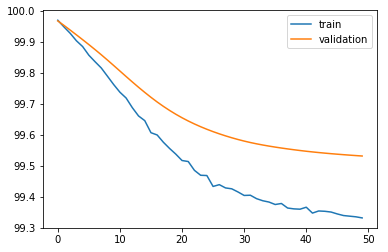

In [14]:
# fit network and save to history
history = model.fit(train_X, train_y, 
                    epochs=50, 
                    batch_size=256, 
                    validation_data=(test_X, test_y), 
                    verbose=2, 
                    shuffle=False)

# plot history
visualize.plot_loss(history)

Train on 648 samples, validate on 163 samples
Epoch 1/50
 - 3s - loss: 99.9540 - val_loss: 99.9256
Epoch 2/50
 - 1s - loss: 99.8592 - val_loss: 99.8601
Epoch 3/50
 - 1s - loss: 99.7612 - val_loss: 99.7916
Epoch 4/50
 - 1s - loss: 99.6655 - val_loss: 99.7225
Epoch 5/50
 - 1s - loss: 99.5796 - val_loss: 99.6588
Epoch 6/50
 - 1s - loss: 99.4850 - val_loss: 99.6063
Epoch 7/50
 - 1s - loss: 99.4332 - val_loss: 99.5745
Epoch 8/50
 - 1s - loss: 99.3897 - val_loss: 99.5537
Epoch 9/50
 - 1s - loss: 99.3610 - val_loss: 99.5401
Epoch 10/50
 - 1s - loss: 99.3416 - val_loss: 99.5317
Epoch 11/50
 - 1s - loss: 99.3286 - val_loss: 99.5252
Epoch 12/50
 - 1s - loss: 99.3181 - val_loss: 99.5199
Epoch 13/50
 - 1s - loss: 99.3137 - val_loss: 99.5155
Epoch 14/50
 - 1s - loss: 99.2960 - val_loss: 99.5119
Epoch 15/50
 - 1s - loss: 99.2920 - val_loss: 99.5088
Epoch 16/50
 - 1s - loss: 99.2779 - val_loss: 99.5062
Epoch 17/50
 - 1s - loss: 99.2764 - val_loss: 99.5039
Epoch 18/50
 - 1s - loss: 99.2709 - val_loss:

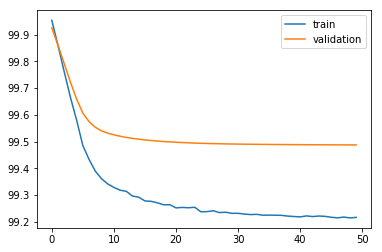

In [15]:
mod.train_model()

# Visualize Results

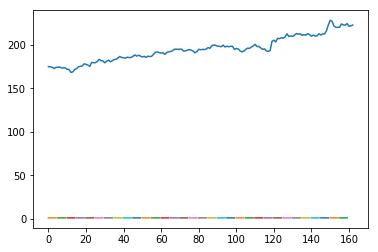

In [16]:
### KEEP THIS WORKING ####
yhat = predicts.predict_sequences_multiple(model, test_X, n_in, n_out)
visualize.plot_results_multiple(yhat, test_y[:,0], n_out, legend=False)
# visualize.plot_single(yhat, test_y, ticker, data_set_category='test')

# Single day predictions

In [17]:
for i, x in enumerate(yhat):
    print(x, test_y[i,0])

[0.9693553, 0.96861416, 0.968154, 0.9670241, 0.9608667] 174.880005
[0.9682232, 0.96747994, 0.966474, 0.9631732, 0.9625381] 174.589996
[0.96684825, 0.9679315, 0.96728706, 0.96520865, 0.96368474] 174.139999
[0.96952724, 0.96879, 0.9684711, 0.96752083, 0.96449184] 172.53999299999995
[0.9693363, 0.9683571, 0.96713996, 0.9659375, 0.9611421] 174.020004
[0.96795404, 0.9685379, 0.96870565, 0.96728444, 0.96410805] 174.119995
[0.96915936, 0.96874, 0.96822435, 0.9671266, 0.9641953] 174.440002
[0.9693116, 0.9686331, 0.96769977, 0.9656981, 0.9614131] 173.240005
[0.9660145, 0.9637133, 0.94896424, 0.94099426, 0.9517121] 173.389999
[0.96703196, 0.9681618, 0.9681517, 0.9669068, 0.9634077] 173.320007
[0.9692484, 0.96874714, 0.96874034, 0.9678222, 0.9647797] 171.809998
[0.96892565, 0.9691885, 0.96885335, 0.96783006, 0.9639858] 171.529999
[0.9690697, 0.96805614, 0.96642244, 0.961609, 0.96270883] 168.119995
[0.9699066, 0.9689971, 0.96841574, 0.9674692, 0.9635462] 168.860001
[0.9680917, 0.9669755, 0.9676267

In [18]:
###### TODO METHOD####
#import predicts
## copy weights
#old_weights=model.get_weights()
#
#new_model = Sequential()
#new_model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2]),
#          return_sequences=True, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(LSTM(10, activation='tanh'))
#new_model.add(Dropout(0.5))
#new_model.add(Dense(1))
#new_model.compile(loss='mae', optimizer='adam')
## fit network
#new_model.set_weights(old_weights)
#predicts.onlineForecast(new_model, test_X, test_y)
## # # ____ # # #

# *** Test Reshaping Method

In [19]:
# test dimension modification
import pandas as pd
df=pd.read_csv('testDim.csv')
features_test=list(df.columns)
df.head()

,Var0,Var1,Var2,Var3,Var4
0,100,101,102,103,104
1,200,201,202,203,204
2,300,301,302,303,304
3,400,401,402,403,404
4,500,501,502,503,504


In [20]:
n_in=2
n_out=1
tgt_tst='Var4'
df=ps.series_to_supervised(df, 
                           n_in=n_in, 
                           n_out=n_out, 
                           features=features_test)
df.head()

starting Series to supverised conversion...


,Var0(t-02),Var1(t-02),Var2(t-02),Var3(t-02),Var4(t-02),Var0(t-01),Var1(t-01),Var2(t-01),Var3(t-01),Var4(t-01),Var0(t),Var1(t),Var2(t),Var3(t),Var4(t)
2,100.0,101.0,102.0,103.0,104.0,200.0,201.0,202.0,203.0,204.0,300,301,302,303,304
3,200.0,201.0,202.0,203.0,204.0,300.0,301.0,302.0,303.0,304.0,400,401,402,403,404
4,300.0,301.0,302.0,303.0,304.0,400.0,401.0,402.0,403.0,404.0,500,501,502,503,504
5,400.0,401.0,402.0,403.0,404.0,500.0,501.0,502.0,503.0,504.0,600,601,602,603,604
6,500.0,501.0,502.0,503.0,504.0,600.0,601.0,602.0,603.0,604.0,700,701,702,703,704


In [21]:
test_frame=ps.frame_targets(df, 
                          features=features_test, 
                          n_out=n_out,
                          target=tgt_tst)
test_frame.head()

,Var0(t-02),Var1(t-02),Var2(t-02),Var3(t-02),Var4(t-02),Var0(t-01),Var1(t-01),Var2(t-01),Var3(t-01),Var4(t-01),Var4(t)
2,100.0,101.0,102.0,103.0,104.0,200.0,201.0,202.0,203.0,204.0,304
3,200.0,201.0,202.0,203.0,204.0,300.0,301.0,302.0,303.0,304.0,404
4,300.0,301.0,302.0,303.0,304.0,400.0,401.0,402.0,403.0,404.0,504
5,400.0,401.0,402.0,403.0,404.0,500.0,501.0,502.0,503.0,504.0,604
6,500.0,501.0,502.0,503.0,504.0,600.0,601.0,602.0,603.0,604.0,704


In [22]:
X = test_frame.values[:, :-n_out]

In [23]:
[print(x) for x in X]

[100. 101. 102. 103. 104. 200. 201. 202. 203. 204.]
[200. 201. 202. 203. 204. 300. 301. 302. 303. 304.]
[300. 301. 302. 303. 304. 400. 401. 402. 403. 404.]
[400. 401. 402. 403. 404. 500. 501. 502. 503. 504.]
[500. 501. 502. 503. 504. 600. 601. 602. 603. 604.]
[600. 601. 602. 603. 604. 700. 701. 702. 703. 704.]
[700. 701. 702. 703. 704. 800. 801. 802. 803. 804.]
[800. 801. 802. 803. 804. 900. 901. 902. 903. 904.]
[ 900.  901.  902.  903.  904. 1000. 1001. 1002. 1003. 1004.]
[1000. 1001. 1002. 1003. 1004. 1100. 1101. 1102. 1103. 1104.]
[1100. 1101. 1102. 1103. 1104. 1200. 1201. 1202. 1203. 1204.]
[1200. 1201. 1202. 1203. 1204. 1300. 1301. 1302. 1303. 1304.]
[1300. 1301. 1302. 1303. 1304. 1400. 1401. 1402. 1403. 1404.]
[1400. 1401. 1402. 1403. 1404. 1500. 1501. 1502. 1503. 1504.]
[1500. 1501. 1502. 1503. 1504. 1600. 1601. 1602. 1603. 1604.]
[1600. 1601. 1602. 1603. 1604. 1700. 1701. 1702. 1703. 1704.]
[1700. 1701. 1702. 1703. 1704. 1800. 1801. 1802. 1803. 1804.]
[1800. 1801. 1802. 1803. 1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [24]:
d=ps.shape(X, n_in, features_test)

AttributeError: module 'processStocks' has no attribute 'shape'

In [ ]:
d[1,-1,:]

* Seems like dim is (observations, n_in, features), which is correct

* tensor should be (t-2)a, (t-2)b, (t-1)a, (t-1)b, etc. where a and b are features to properly reshape, thus current reshaping is working as expected